In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import sys
sys.path.append("..")

In [2]:
P_0 = 0.5
P_1 = 1-P_0

P_00 = 0.5
P_10 = 1-P_00

P_01 = 0.5
P_11 = 1-P_01

p_z = {}
p_z[0] = P_0
p_z[1] = P_1
p_yz = {}
p_yz[0,0] = P_00
p_yz[0,1] = P_01
p_yz[1,0] = P_10
p_yz[1,1] = P_11

mu_yz = {}
mu_yz[0,0] = np.array([1,-6])
mu_yz[0,1] = np.array([-1,-2])
mu_yz[1,0] = np.array([2,1.5])
mu_yz[1,1] = np.array([1,2.5])

sigma_yz = {}
sigma_yz[0,0] = 0.25*np.diag([1,1])
sigma_yz[0,1] = 0.25*np.diag([1,1])
sigma_yz[1,0] = 0.25*np.diag([1,1])
sigma_yz[1,1] = 0.25*np.diag([1,1])
delta = 1.5

def error_rate(theta_0, b_0, P_z, P_yz, mu_yz, sigma_yz):
    v_0 = np.array([np.sin(theta_0),np.cos(theta_0)])
    err_0 = P_yz[1,0]*norm.sf((v_0.T@mu_yz[1,0]-b_0)/np.sqrt(v_0.T@sigma_yz[1,0]@v_0.T))
    err_0 += P_yz[0,0]*norm.sf((b_0-v_0.T@mu_yz[0,0])/np.sqrt(v_0.T@sigma_yz[0,0]@v_0.T))
    err_1 = P_yz[1,1]*norm.sf((v_0.T@mu_yz[1,1]-b_0)/np.sqrt(v_0.T@sigma_yz[1,1]@v_0.T))
    err_1 += P_yz[0,1]*norm.sf((b_0-v_0.T@mu_yz[0,1])/np.sqrt(v_0.T@sigma_yz[0,1]@v_0.T))
    err = P_z[0]*err_0 + P_z[1]*err_1
    return err

def ei_violation(theta_0, b_0, P_z, P_yz, mu_yz, sigma_yz, delta):
    v_0 = np.array([np.sin(theta_0),np.cos(theta_0)])
    p_00 = P_yz[1,0]*norm.sf((v_0.T@mu_yz[1,0]-b_0)/np.sqrt(v_0.T@sigma_yz[1,0]@v_0.T))
    p_00 += P_yz[0,0]*norm.sf((v_0.T@mu_yz[0,0]-b_0)/np.sqrt(v_0.T@sigma_yz[0,0]@v_0.T))
    b_0_s = b_0-delta*np.sqrt(np.sum(np.square(v_0)))
    p_00_improvable = P_yz[1,0]*norm.sf((v_0.T@mu_yz[1,0]-b_0_s)/np.sqrt(v_0.T@sigma_yz[1,0]@v_0.T))
    p_00_improvable += P_yz[0,0]*norm.sf((v_0.T@mu_yz[0,0]-b_0_s)/np.sqrt(v_0.T@sigma_yz[0,0]@v_0.T))
    p_00_improvable = p_00-p_00_improvable
    ei_0 = p_00_improvable/p_00
    p_01 = P_yz[1,1]*norm.sf((v_0.T@mu_yz[1,1]-b_0)/np.sqrt(v_0.T@sigma_yz[1,1]@v_0.T))
    p_01 += P_yz[0,1]*norm.sf((v_0.T@mu_yz[0,1]-b_0)/np.sqrt(v_0.T@sigma_yz[0,1]@v_0.T))
    b_0_s = b_0-delta*np.sqrt(np.sum(np.square(v_0)))
    p_01_improvable = P_yz[1,1]*norm.sf((v_0.T@mu_yz[1,1]-b_0_s)/np.sqrt(v_0.T@sigma_yz[1,1]@v_0.T))
    p_01_improvable += P_yz[0,1]*norm.sf((v_0.T@mu_yz[0,1]-b_0_s)/np.sqrt(v_0.T@sigma_yz[0,1]@v_0.T))
    p_01_improvable = p_01-p_01_improvable
    ei_1 = p_01_improvable/p_01
    ei = P_z[0]*ei_0+P_z[1]*ei_1
    return max(abs(ei-ei_0),abs(ei-ei_1))

def er_violation(theta_0, b_0, P_z, P_yz, mu_yz, sigma_yz):
    v_0 = np.array([np.sin(theta_0),np.cos(theta_0)])
    er_0 = P_yz[1,0]*norm.expect(lambda x: -min(0,x/np.linalg.norm(v_0)),loc=v_0.T@mu_yz[1,0]-b_0,scale=np.sqrt(v_0.T@sigma_yz[1,0]@v_0.T))/norm.expect(lambda x: x<=0,loc=v_0.T@mu_yz[1,0]-b_0,scale=np.sqrt(v_0.T@sigma_yz[1,0]@v_0.T))
    er_0 += P_yz[0,0]*norm.expect(lambda x: -min(0,x/np.linalg.norm(v_0)),loc=v_0.T@mu_yz[0,0]-b_0,scale=np.sqrt(v_0.T@sigma_yz[0,0]@v_0.T))/norm.expect(lambda x: x<=0,loc=v_0.T@mu_yz[0,0]-b_0,scale=np.sqrt(v_0.T@sigma_yz[0,0]@v_0.T))
    er_1 = P_yz[1,1]*norm.expect(lambda x: -min(0,x/np.linalg.norm(v_0)),loc=v_0.T@mu_yz[1,1]-b_0,scale=np.sqrt(v_0.T@sigma_yz[1,1]@v_0.T))/norm.expect(lambda x: x<=0,loc=v_0.T@mu_yz[1,1]-b_0,scale=np.sqrt(v_0.T@sigma_yz[1,1]@v_0.T))
    er_1 += P_yz[0,1]*norm.expect(lambda x: -min(0,x/np.linalg.norm(v_0)),loc=v_0.T@mu_yz[0,1]-b_0,scale=np.sqrt(v_0.T@sigma_yz[0,1]@v_0.T))/norm.expect(lambda x: x<=0,loc=v_0.T@mu_yz[0,1]-b_0,scale=np.sqrt(v_0.T@sigma_yz[0,1]@v_0.T))
    er = P_z[0]*er_0+P_z[1]*er_1
    return max(abs(er-er_0),abs(er-er_1))


In [3]:

P_0_o = 11/21
P_1_o = 1-P_0_o

P_00_o = 0.5
P_20_o = 1/11
P_10_o = 1-P_20_o

P_01_o = 0.5
P_11_o = 1-P_01_o

p_z_o = {}
p_z_o[0] = P_0_o
p_z_o[1] = P_1_o
p_yz_o = {}
p_yz_o[0,0] = P_00_o
p_yz_o[0,1] = P_01_o
p_yz_o[1,0] = P_10_o
p_yz_o[2,0] = P_20_o
p_yz_o[1,1] = P_11_o

mu_yz_o = {}
mu_yz_o[0,0] = np.array([1,-6])
mu_yz_o[0,1] = np.array([-1,-2])
mu_yz_o[2,0] = np.array([-1,-20])
mu_yz_o[1,0] = np.array([2,1.5])
mu_yz_o[1,1] = np.array([1,2.5])

sigma_yz_o = {}
sigma_yz_o[0,0] = 0.25*np.diag([1,1])
sigma_yz_o[0,1] = 0.25*np.diag([1,1])
sigma_yz_o[2,0] = 0.05*np.diag([1,1])
sigma_yz_o[1,0] = 0.25*np.diag([1,1])
sigma_yz_o[1,1] = 0.25*np.diag([1,1])
delta = 1.5

def error_rate_o(theta_0, b_0, P_z, P_yz, mu_yz, sigma_yz):
    v_0 = np.array([np.sin(theta_0),np.cos(theta_0)])
    err_0 = P_yz[1,0]*norm.sf((v_0.T@mu_yz[1,0]-b_0)/np.sqrt(v_0.T@sigma_yz[1,0]@v_0.T))
    err_0 += P_yz[0,0]*norm.sf((b_0-v_0.T@mu_yz[0,0])/np.sqrt(v_0.T@sigma_yz[0,0]@v_0.T))
    err_0 += P_yz[2,0]*norm.sf((b_0-v_0.T@mu_yz[2,0])/np.sqrt(v_0.T@sigma_yz[2,0]@v_0.T))
    err_1 = P_yz[1,1]*norm.sf((v_0.T@mu_yz[1,1]-b_0)/np.sqrt(v_0.T@sigma_yz[1,1]@v_0.T))
    err_1 += P_yz[0,1]*norm.sf((b_0-v_0.T@mu_yz[0,1])/np.sqrt(v_0.T@sigma_yz[0,1]@v_0.T))
    err = P_z[0]*err_0 + P_z[1]*err_1
    return err

def ei_violation_o(theta_0, b_0, P_z, P_yz, mu_yz, sigma_yz, delta):
    v_0 = np.array([np.sin(theta_0),np.cos(theta_0)])
    p_00 = P_yz[1,0]*norm.sf((v_0.T@mu_yz[1,0]-b_0)/np.sqrt(v_0.T@sigma_yz[1,0]@v_0.T))
    p_00 += P_yz[0,0]*norm.sf((v_0.T@mu_yz[0,0]-b_0)/np.sqrt(v_0.T@sigma_yz[0,0]@v_0.T))
    p_00 += P_yz[2,0]*norm.sf((v_0.T@mu_yz[2,0]-b_0)/np.sqrt(v_0.T@sigma_yz[2,0]@v_0.T))
    b_0_s = b_0-delta*np.sqrt(np.sum(np.square(v_0)))
    p_00_improvable = P_yz[1,0]*norm.sf((v_0.T@mu_yz[1,0]-b_0_s)/np.sqrt(v_0.T@sigma_yz[1,0]@v_0.T))
    p_00_improvable += P_yz[0,0]*norm.sf((v_0.T@mu_yz[0,0]-b_0_s)/np.sqrt(v_0.T@sigma_yz[0,0]@v_0.T))
    p_00_improvable += P_yz[2,0]*norm.sf((v_0.T@mu_yz[2,0]-b_0_s)/np.sqrt(v_0.T@sigma_yz[2,0]@v_0.T))
    p_00_improvable = p_00-p_00_improvable
    ei_0 = p_00_improvable/p_00
    p_01 = P_yz[1,1]*norm.sf((v_0.T@mu_yz[1,1]-b_0)/np.sqrt(v_0.T@sigma_yz[1,1]@v_0.T))
    p_01 += P_yz[0,1]*norm.sf((v_0.T@mu_yz[0,1]-b_0)/np.sqrt(v_0.T@sigma_yz[0,1]@v_0.T))
    b_0_s = b_0-delta*np.sqrt(np.sum(np.square(v_0)))
    p_01_improvable = P_yz[1,1]*norm.sf((v_0.T@mu_yz[1,1]-b_0_s)/np.sqrt(v_0.T@sigma_yz[1,1]@v_0.T))
    p_01_improvable += P_yz[0,1]*norm.sf((v_0.T@mu_yz[0,1]-b_0_s)/np.sqrt(v_0.T@sigma_yz[0,1]@v_0.T))
    p_01_improvable = p_01-p_01_improvable
    ei_1 = p_01_improvable/p_01
    ei = P_z[0]*ei_0+P_z[1]*ei_1
    return max(abs(ei-ei_0),abs(ei-ei_1))

def er_violation_o(theta_0, b_0, P_z, P_yz, mu_yz, sigma_yz):
    v_0 = np.array([np.sin(theta_0),np.cos(theta_0)])
    er_0 = P_yz[1,0]*norm.expect(lambda x: -min(0,x/np.linalg.norm(v_0)),loc=v_0.T@mu_yz[1,0]-b_0,scale=np.sqrt(v_0.T@sigma_yz[1,0]@v_0.T))/norm.expect(lambda x: x<=0,loc=v_0.T@mu_yz[1,0]-b_0,scale=np.sqrt(v_0.T@sigma_yz[1,0]@v_0.T))
    er_0 += P_yz[0,0]*norm.expect(lambda x: -min(0,x/np.linalg.norm(v_0)),loc=v_0.T@mu_yz[0,0]-b_0,scale=np.sqrt(v_0.T@sigma_yz[0,0]@v_0.T))/norm.expect(lambda x: x<=0,loc=v_0.T@mu_yz[0,0]-b_0,scale=np.sqrt(v_0.T@sigma_yz[0,0]@v_0.T))
    er_0 += P_yz[2,0]*norm.expect(lambda x: -min(0,x/np.linalg.norm(v_0)),loc=v_0.T@mu_yz[2,0]-b_0,scale=np.sqrt(v_0.T@sigma_yz[2,0]@v_0.T))/norm.expect(lambda x: x<=0,loc=v_0.T@mu_yz[2,0]-b_0,scale=np.sqrt(v_0.T@sigma_yz[2,0]@v_0.T))
    er_1 = P_yz[1,1]*norm.expect(lambda x: -min(0,x/np.linalg.norm(v_0)),loc=v_0.T@mu_yz[1,1]-b_0,scale=np.sqrt(v_0.T@sigma_yz[1,1]@v_0.T))/norm.expect(lambda x: x<=0,loc=v_0.T@mu_yz[1,1]-b_0,scale=np.sqrt(v_0.T@sigma_yz[1,1]@v_0.T))
    er_1 += P_yz[0,1]*norm.expect(lambda x: -min(0,x/np.linalg.norm(v_0)),loc=v_0.T@mu_yz[0,1]-b_0,scale=np.sqrt(v_0.T@sigma_yz[0,1]@v_0.T))/norm.expect(lambda x: x<=0,loc=v_0.T@mu_yz[0,1]-b_0,scale=np.sqrt(v_0.T@sigma_yz[0,1]@v_0.T))
    er = P_z[0]*er_0+P_z[1]*er_1
    return max(abs(er-er_0),abs(er-er_1))


In [4]:
err_rate = lambda x: error_rate(x[0],x[1],p_z,p_yz,mu_yz,sigma_yz) 
ei_disp = lambda x: ei_violation(x[0],x[1],p_z,p_yz,mu_yz,sigma_yz,delta) 
er_disp = lambda x: er_violation(x[0],x[1],p_z,p_yz,mu_yz,sigma_yz) 

err_rate_o = lambda x: error_rate_o(x[0],x[1],p_z_o,p_yz_o,mu_yz_o,sigma_yz_o) 
ei_disp_o = lambda x: ei_violation_o(x[0],x[1],p_z_o,p_yz_o,mu_yz_o,sigma_yz_o,delta) 
er_disp_o = lambda x: er_violation_o(x[0],x[1],p_z_o,p_yz_o,mu_yz_o,sigma_yz_o) 

from scipy.optimize import Bounds
bounds = Bounds([0, -20], [2*np.pi, 20])

from scipy.optimize import NonlinearConstraint
from scipy.optimize import BFGS
nonlinear_constraint = NonlinearConstraint(ei_disp, -0.0, 0.0, jac='2-point', hess=BFGS())

x0 = np.array([0, 0])
res = minimize(err_rate, x0, method='trust-constr', options={'verbose': 1}, bounds=bounds)


nonlinear_constraint = NonlinearConstraint(ei_disp, -0, 0, jac='2-point', hess=BFGS())
res_cons_ei = minimize(err_rate, x0, method='trust-constr',constraints=[nonlinear_constraint],options={'verbose': 1}, bounds=bounds)
nonlinear_constraint = NonlinearConstraint(er_disp, -0, 0, jac='2-point', hess=BFGS())
res_cons_er = minimize(err_rate, x0, method='trust-constr',constraints=[nonlinear_constraint],options={'verbose': 1}, bounds=bounds)

nonlinear_constraint = NonlinearConstraint(ei_disp_o, -0, 0, jac='2-point', hess=BFGS())
res_cons_ei_o = minimize(err_rate_o, x0, method='trust-constr',constraints=[nonlinear_constraint],options={'verbose': 1}, bounds=bounds)
nonlinear_constraint = NonlinearConstraint(er_disp_o, -0, 0, jac='2-point', hess=BFGS())
res_cons_er_o = minimize(err_rate_o, x0, method='trust-constr',constraints=[nonlinear_constraint],options={'verbose': 1}, bounds=bounds)

`gtol` termination condition is satisfied.
Number of iterations: 24, function evaluations: 42, CG iterations: 20, optimality: 1.99e-09, constraint violation: 0.00e+00, execution time: 0.051 s.
`gtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 84, CG iterations: 23, optimality: 1.94e-09, constraint violation: 2.51e-09, execution time: 0.068 s.


/opt/homebrew/Caskroom/miniforge/base/envs/sampler_fairness/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 75, function evaluations: 264, CG iterations: 63, optimality: 1.75e-06, constraint violation: 2.56e-10, execution time: 3.1e+01 s.
`xtol` termination condition is satisfied.
Number of iterations: 49, function evaluations: 195, CG iterations: 37, optimality: 6.01e-07, constraint violation: 3.27e-12, execution time: 0.13 s.
`xtol` termination condition is satisfied.
Number of iterations: 163, function evaluations: 744, CG iterations: 151, optimality: 6.74e-02, constraint violation: 1.02e-09, execution time: 1.2e+02 s.


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
def create_data(pct=0.8,rstate=0):
    N = 400
    x_00 = np.random.multivariate_normal(np.array([1,-6]), 0.25*np.eye(2), N)
    z = -1*np.ones([N,1])
    y = -1*np.ones([N,1])
    t_00 = np.hstack([y,z,x_00])
    x_01 = np.random.multivariate_normal(np.array([-1,-2]), 0.25*np.eye(2), N)
    z = np.ones([N,1])
    y = -1*np.ones([N,1])
    t_01 = np.hstack([y,z,x_01])
    x_10 = np.random.multivariate_normal(np.array([2,1.5]), 0.25*np.eye(2), N)
    z = -1*np.ones([N,1])
    y = np.ones([N,1])
    t_10 = np.hstack([y,z,x_10])
    x_11 = np.random.multivariate_normal(np.array([1,2.5]), 0.25*np.eye(2), N)
    z = np.ones([N,1])
    y = np.ones([N,1])
    t_11 = np.hstack([y,z,x_11])
    array = np.vstack([t_00,t_01,t_10,t_11])

    x_11 = np.random.multivariate_normal(np.array([-1,-20]), 0.05*np.eye(2), N//5)
    z = -1*np.ones([N//5,1])
    y = -1*np.ones([N//5,1])
    t_000 = np.hstack([y,z,x_11])
    array_outlier = np.vstack([t_00,t_01,t_10,t_11,t_000])
    data = pd.DataFrame(array)
    data = data.sample(frac=1).reset_index(drop=True)
    data = data.to_numpy()
    df = {}

    df['trainx'], df['testx'], df['traingrp'], df['testgrp'], df['trainy'], df['testy'] = train_test_split(data[:,2:], data[:,1], data[:,0], test_size=pct, random_state=rstate)
    df['both'] = np.concatenate((df['trainx'], df['testx']), axis=0)

    df['train'] = np.hstack((df['traingrp'].reshape(-1, 1), df['trainx']))
    df['test'] = np.hstack((df['testgrp'].reshape(-1, 1), df['testx']))

    data_outlier = pd.DataFrame(array_outlier)
    data_outlier = data_outlier.sample(frac=1).reset_index(drop=True)
    data_outlier = data_outlier.to_numpy()
    df_outlier = {}

    df_outlier['trainx'], df_outlier['testx'], df_outlier['traingrp'], df_outlier['testgrp'], df_outlier['trainy'], df_outlier['testy'] = train_test_split(data_outlier[:,2:], data_outlier[:,1], data_outlier[:,0], test_size=pct, random_state=rstate)
    df_outlier['both'] = np.concatenate((df_outlier['trainx'], df_outlier['testx']), axis=0)

    df_outlier['train'] = np.hstack((df_outlier['traingrp'].reshape(-1, 1), df_outlier['trainx']))
    df_outlier['test'] = np.hstack((df_outlier['testgrp'].reshape(-1, 1), df_outlier['testx']))

    return df, df_outlier, 2


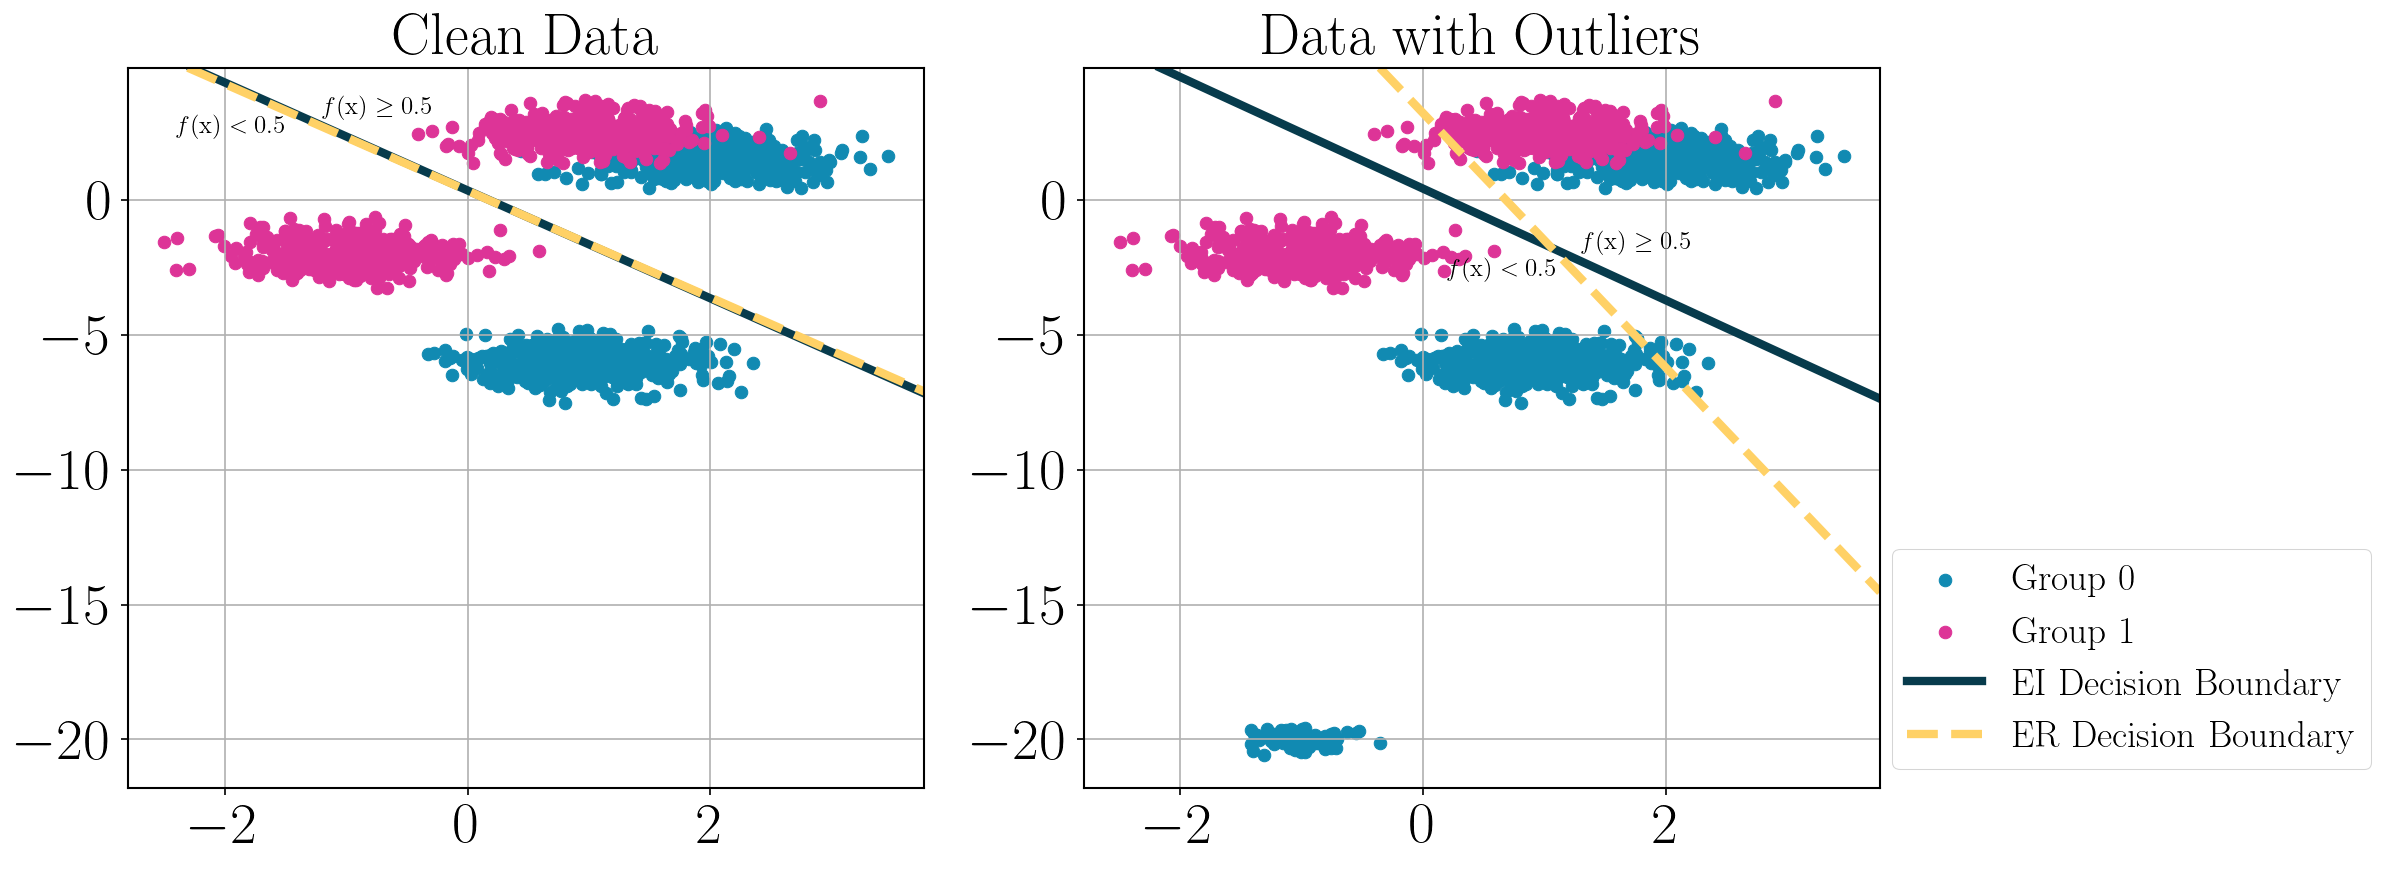

In [6]:
np.random.seed(0)
data, data_outlier, d = create_data(pct=0.2,rstate=0)

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines

width = 16
height = 6

plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.rc('axes', titlesize=28)
plt.rc('legend', fontsize=18)
plt.rc('axes', labelsize=28)
plt.rc('axes', linewidth=1)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True) #plot two subgraphs in one figure, 1 by 2 size, sharing y-axis
#fig.subplots_adjust(left=0.06, bottom=.19, right=0.99, top=0.95, wspace=0.01) #margin of the figure
fig.set_size_inches(width, height) #exact size of the figure
fig.set_dpi(150)

colors = ['#073B4C','#118AB2','#DD3497','#FFD166']
data['both_group'] = np.concatenate((data['traingrp'], data['testgrp']), axis=0)
t1 = ax[0].scatter(data['both'][data['both_group']==-1,0],data['both'][data['both_group']==-1,1],c=colors[1],label='Group 0')
t2 = ax[0].scatter(data['both'][data['both_group']==1,0],data['both'][data['both_group']==1,1],c=colors[2],label='Group 1')
slope = -np.sin(res_cons_ei.x[0])/np.cos(res_cons_ei.x[0])
intercept = res_cons_ei.x[1]/np.cos(res_cons_ei.x[0])
ax[0].axline((0,intercept), slope=slope, color=colors[0], label='EI Decision Boundary',linewidth=4)
slope = -np.sin(res_cons_er.x[0])/np.cos(res_cons_er.x[0])
intercept = res_cons_er.x[1]/np.cos(res_cons_er.x[0])
ax[0].axline((0,intercept), slope=slope, color=colors[3], label='ER Decision Boundary',linewidth=4,linestyle='--')
ax[0].text(-2.4, 2.5, '$f(\mathrm{x})<0.5$', fontsize = 12)
ax[0].text(-1.2, 3.2, '$f(\mathrm{x})\geq 0.5$', fontsize = 12)
ax[0].set_title(r'Clean Data')
ax[0].grid()

data_outlier['both_group'] = np.concatenate((data_outlier['traingrp'], data_outlier['testgrp']), axis=0)
t1 = ax[1].scatter(data_outlier['both'][data_outlier['both_group']==-1,0],data_outlier['both'][data_outlier['both_group']==-1,1],c=colors[1],label='Group 0')
t2 = ax[1].scatter(data_outlier['both'][data_outlier['both_group']==1,0],data_outlier['both'][data_outlier['both_group']==1,1],c=colors[2],label='Group 1')
slope = -np.sin(res_cons_ei_o.x[0])/np.cos(res_cons_ei_o.x[0])
intercept = res_cons_ei_o.x[1]/np.cos(res_cons_ei_o.x[0])
ax[1].axline((0,intercept), slope=slope, color=colors[0], label='EI Decision Boundary',linewidth=4)
slope = -np.sin(res_cons_er_o.x[0])/np.cos(res_cons_er_o.x[0])
intercept = res_cons_er_o.x[1]/np.cos(res_cons_er_o.x[0])
ax[1].axline((0,intercept), slope=slope, color=colors[3], label='ER Decision Boundary',linewidth=4, linestyle='--')
ax[1].text(0.2, -2.8, '$f(\mathrm{x})<0.5$', fontsize = 12)
ax[1].text(1.3, -1.8, '$f(\mathrm{x})\geq 0.5$', fontsize = 12, weight='bold')
ax[1].set_title(r'Data with Outliers')
ax[1].grid()
ax[1].yaxis.set_tick_params(labelbottom=True)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.64, 0))
plt.gcf().set_dpi(150)
plt.subplots_adjust(top=0.9,bottom=0.1,left=0.06,right=0.79)
plt.savefig('results/ER_Outlier_opt.pdf')
plt.show()



In [7]:
print(err_rate(res_cons_ei_o.x))
print(ei_disp(res_cons_ei_o.x))
print(er_disp(res_cons_ei_o.x))

6.941037174608208e-05
0.016756967790398425
0.020272039376212803


In [8]:
print(err_rate(res_cons_er_o.x))
print(ei_disp(res_cons_er_o.x))
print(er_disp(res_cons_er_o.x))

0.019999140540857403
0.34811251835756774
0.2908461297340158
